In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class AlzheimerDataset(Dataset):
  def __init__(self, root, transform, ext='jpg'):
    self.paths = []
    self.labels = []

    # Create label encoder
    self.label_encoder = {cat:index for index, cat in \
                          enumerate(cat for cat in os.listdir(root) if\
                                    os.path.isdir(os.path.join(root, cat)) and\
                                    not cat.startswith('.') )}

    self.transform = transform
    self.label_decoder = {index:cat for cat, index in  self.label_encoder.items()}
    
    for cat in self.label_encoder.keys():
        category_path = glob.glob(os.path.join(root, cat, f'*.{ext}'))
        self.paths += category_path
        self.labels += [self.label_encoder[cat]] * len(category_path)
    
    assert len(self.paths) == len(self.labels), "Number of image paths and labels should be equal"
    
  def __len__(self):
    return len(self.paths)

  def __getitem__(self, i):
    image = Image.open(self.paths[i])
    if self.transform is not None:
        image = self.transform(image)
    label = self.labels[i]
    return image, label

In [ ]:
# Augmentation
img_transform = transforms.Compose(
    [
        transforms.ToTensor(),
     ])

In [ ]:
base_root = '/content/drive/MyDrive/AlzheimerMRI'

dataset = AlzheimerDataset(base_root, img_transform)
print(len(dataset))

6402


In [ ]:
train_dataset, test_dataset = random_split(dataset, [5200, 1202], generator=torch.Generator().manual_seed(999))
train_dataset, val_dataset = random_split(train_dataset, [3900, 1300], generator=torch.Generator().manual_seed(999))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=44e2cbaf2497188cda4a0f656c6abd86c809dd71fa5b0fa05c0f133ab2bb6991
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

# Initialize the model and optimizer
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

# Modify the first layer to accept grayscale images
num_out_channels = model._conv_stem.out_channels

# Create a new first layer with one input channel
new_first_layer = torch.nn.Conv2d(1, num_out_channels, kernel_size=3, stride=2, padding=1, bias=False)

# Set the new first layer as the first layer in the EfficientNet model
model._conv_stem = new_first_layer

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 117MB/s] 


Loaded pretrained weights for efficientnet-b0


In [ ]:
# Freeze the parameters of the fully connected layer
def freeze_layers(model):
    for name, param in model.named_parameters():
        if 'fc' in name:
            param.requires_grad = False

# Call the freeze_layers function to freeze the desired layers
freeze_layers(model)


In [ ]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0  # Variable to keep track of the best validation accuracy

for epoch in range(3):
    # Train
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        running_train_acc += (predicted == labels).sum().item()

        # Compute training loss
        running_train_loss += loss.item()

    # Compute average training accuracy and loss for the epoch
    epoch_train_acc = running_train_acc / len(train_loader.dataset)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_accs.append(epoch_train_acc)
    train_losses.append(epoch_train_loss)

    # Validate
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    for i, (images, labels) in enumerate(validation_loader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        # Compute validation accuracy
        _, predicted = torch.max(outputs.data, 1)
        running_val_acc += (predicted == labels).sum().item()

        # Compute validation loss
        running_val_loss += loss.item()

    # Compute average validation accuracy and loss for the epoch
    epoch_val_acc = running_val_acc / len(validation_loader.dataset)
    epoch_val_loss = running_val_loss / len(validation_loader.dataset)
    val_accs.append(epoch_val_acc)
    val_losses.append(epoch_val_loss)

    # Save the best model if current validation accuracy is better
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print progress
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
          .format(epoch + 1, 10, epoch_train_loss, epoch_train_acc * 100, epoch_val_loss, epoch_val_acc * 100))


Epoch [1/10], Train Loss: 0.0075, Train Acc: 96.85%, Val Loss: 0.0303, Val Acc: 87.46%
Epoch [2/10], Train Loss: 0.0078, Train Acc: 96.15%, Val Loss: 0.0256, Val Acc: 83.85%
Epoch [3/10], Train Loss: 0.0076, Train Acc: 96.79%, Val Loss: 0.0313, Val Acc: 79.23%


In [ ]:
# Load the best model
best_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)  # Replace with the appropriate EfficientNet variant and number of classes
# Modify the first layer to accept grayscale images
# Get the number of output channels of the first layer
num_out_channels = best_model._conv_stem.out_channels

# Create a new first layer with one input channel
new_first_layer = torch.nn.Conv2d(1, num_out_channels, kernel_size=3, stride=2, padding=1, bias=False)

# Set the new first layer as the first layer in the EfficientNet model
best_model._conv_stem = new_first_layer

best_model.load_state_dict(torch.load('best_model.pth'))  # Load the saved best model weights
best_model._conv_stem = model._conv_stem  # Use the modified first layer from the original model
best_model.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
        (static_padding): Identity()
      )
      (_bn2): 

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# Initialize variables
total_correct = 0
total_loss = 0
total = 0
all_predictions = []
all_labels = []

criterion = nn.CrossEntropyLoss()

best_model.eval()  # Set the best model to evaluation mode

# Iterate over the test data
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = best_model(images)  # Use the best model for inference
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        total += images.size(0)
        
        _, predictions = outputs.max(1)
        
        total_correct += (labels == predictions).sum()
        
        # Append predictions and labels to the respective lists
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate loss and accuracy
loss = total_loss / total
accuracy = total_correct.item() / total * 100

# Print test accuracy
print('Test Acc: {:.2f}%'.format(accuracy))


Test Acc: 88.10%


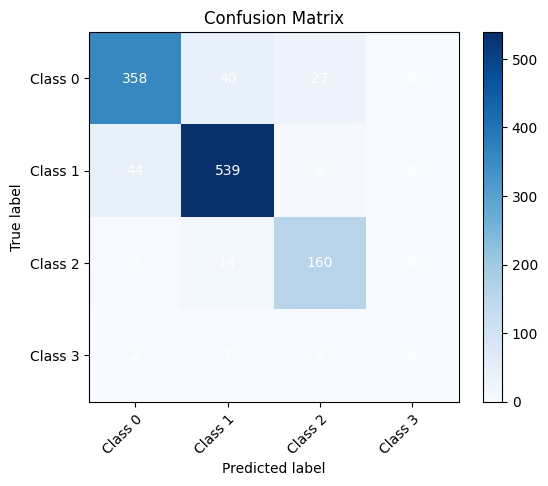

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

confusion = confusion_matrix(all_labels, all_predictions)

# Creating the confusion matrix plot
fig, ax = plt.subplots()
im = ax.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set labels for the x and y axes
ax.set(xticks=np.arange(confusion.shape[1]),
       yticks=np.arange(confusion.shape[0]),
       xticklabels=['Class {}'.format(i) for i in range(confusion.shape[1])],
       yticklabels=['Class {}'.format(i) for i in range(confusion.shape[0])],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the x-axis labels for better readability if needed
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(j, i, format(confusion[i, j], 'd'),
                ha="center", va="center", color="white")

# Display the plot
plt.show()


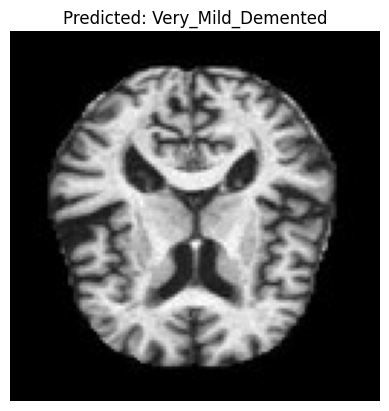

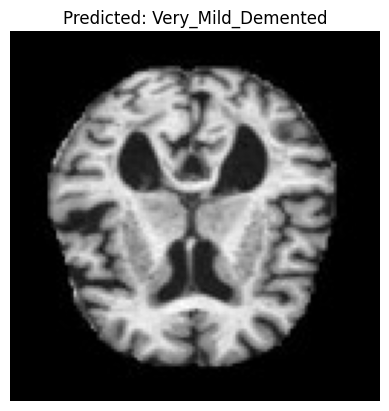

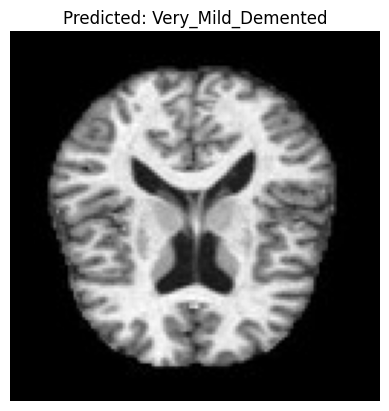

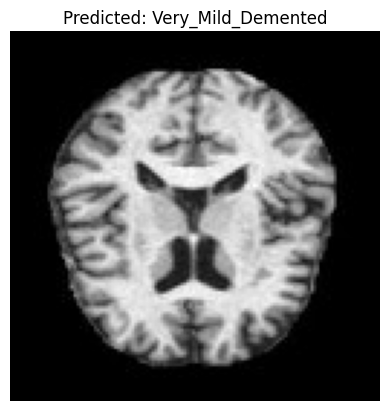

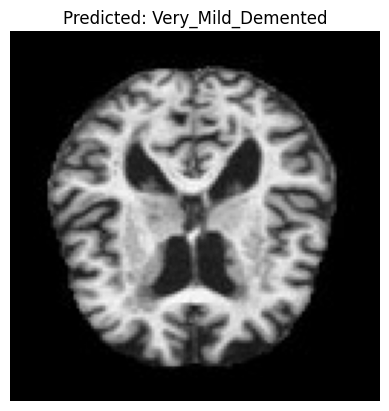

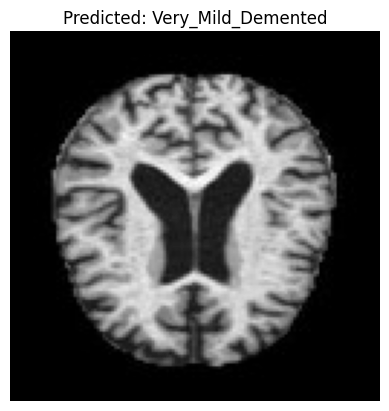

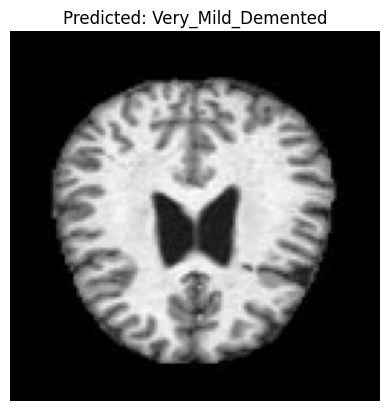

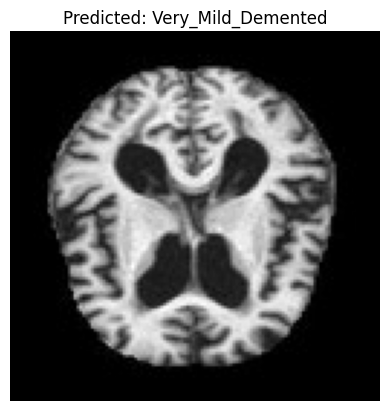

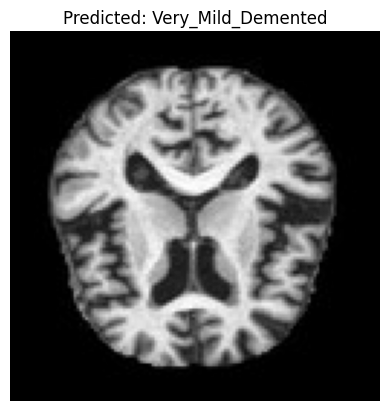

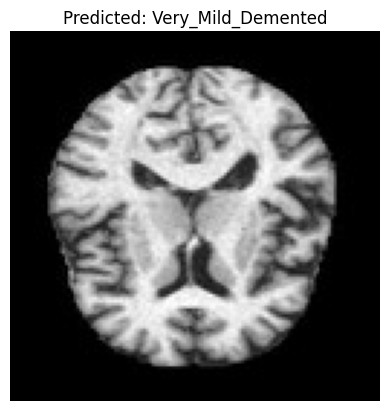

In [ ]:
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
best_model.eval()

# Iterate over a few test samples
for i in range(10):
    # Get a test sample and its corresponding label
    image, label = test_dataset.dataset[i]
    
    # Prepare the image for prediction
    image = image.unsqueeze(0).to(device)
    
    # Perform the prediction
    with torch.no_grad():
        output = best_model(image)
        _, predicted_label = output.max(1)
    
    # Convert the predicted label to a human-readable class name
    predicted_class = test_dataset.dataset.label_decoder[predicted_label.item()]
    
    # Convert the image tensor to a NumPy array
    image_np = image.squeeze().cpu().numpy()
    
    # Plot the image with the predicted label
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.4 MB/s eta 0:00:00


In [ ]:
import shap
model = model.to(device)
image = images.to(device)

# Get a batch of test images
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)

# Create the DeepExplainer object
e = shap.DeepExplainer(model, images)

# Select some test images to compute SHAP values
test_images = images[:10]

# Compute the SHAP values
shap_values = e.shap_values(test_images)

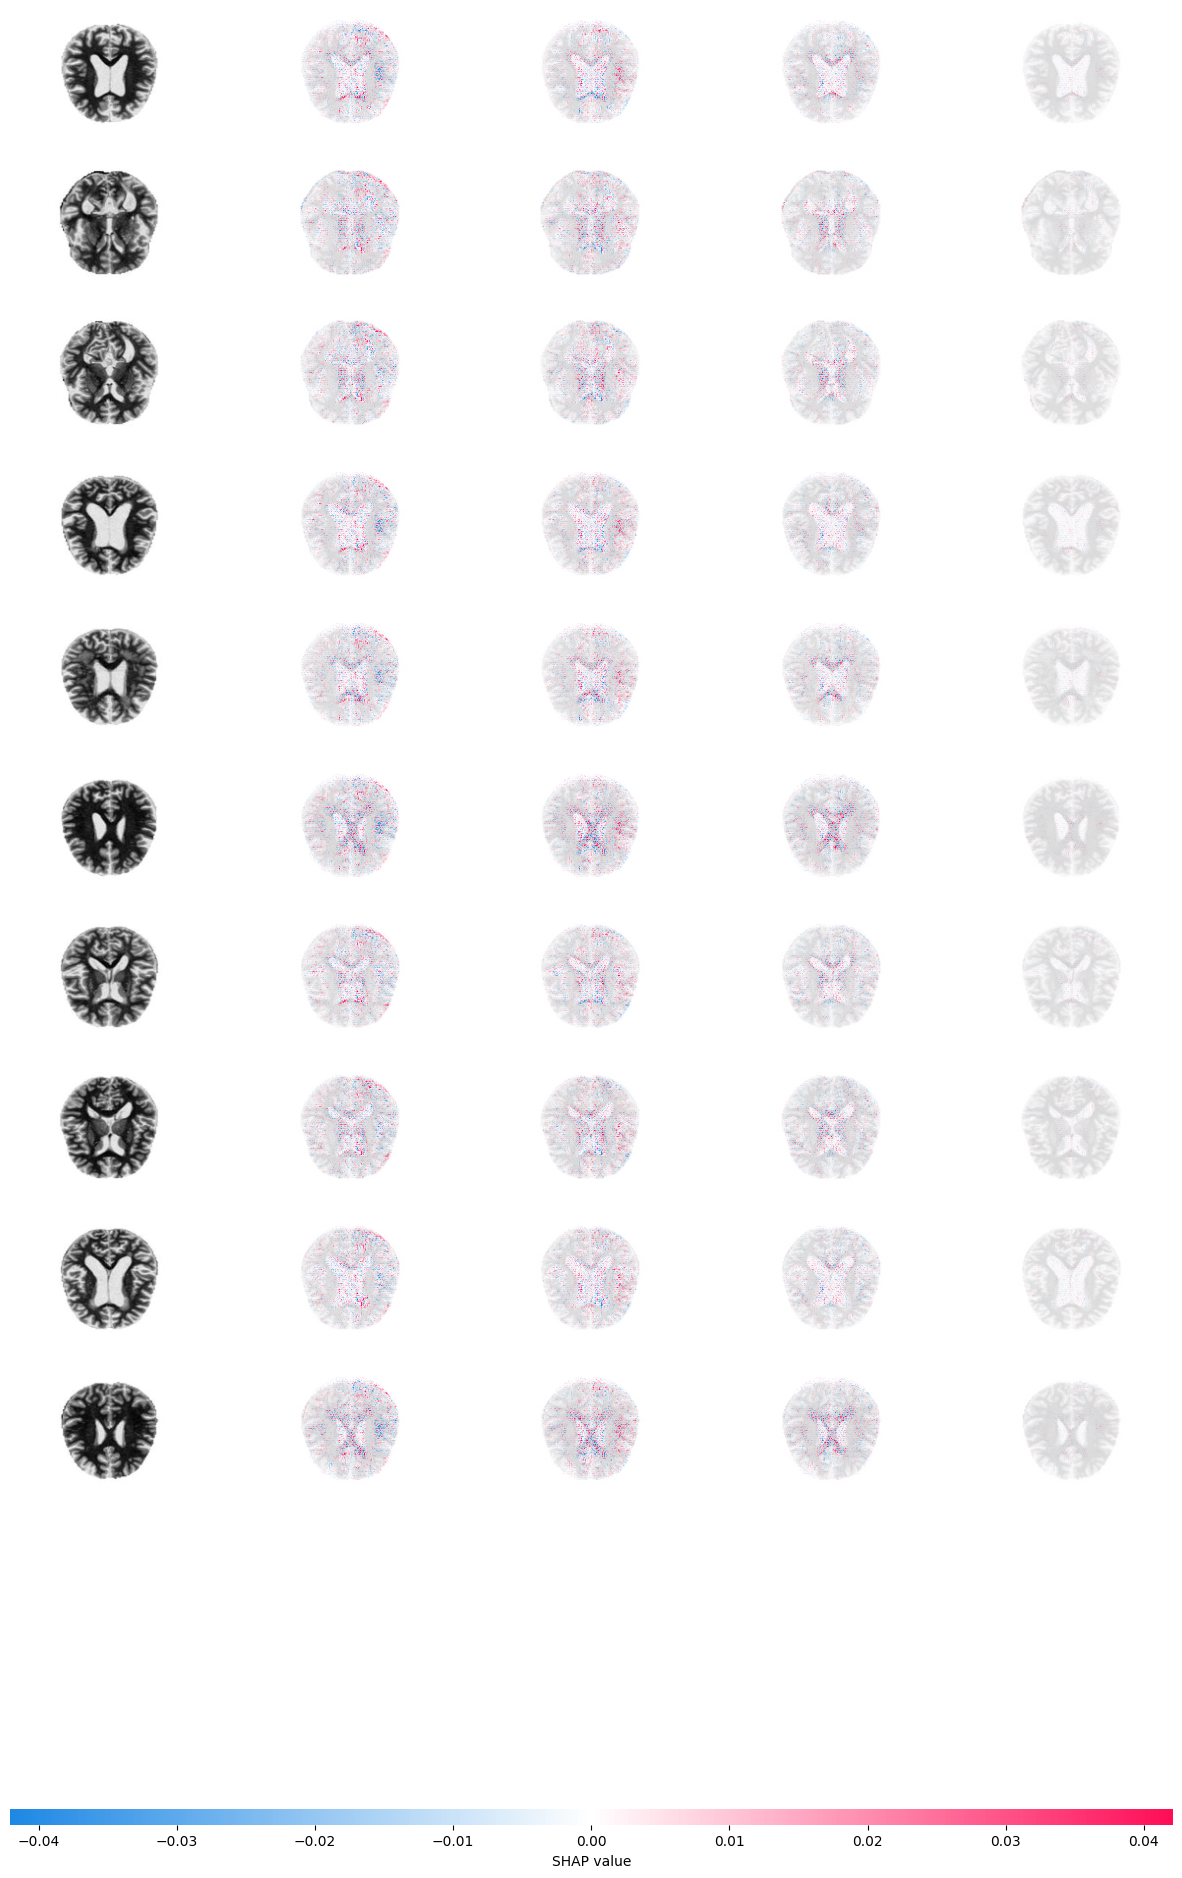

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)
